## ANALYSIS

In [1]:
## -----------IMPORT LIBRARIES
import pandas as pd #for dealing with csv import
import os # for joining paths and filenames sensibly
import numpy as np #for the population std
import glob # for finding csv data Çfiles
import platform # paths use different dividers on linux vs windows, so we need to test for this
import csv


In [13]:
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\juncar_all'
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\guinardo_all'
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\guinardo_all2'
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\coles'  
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\Pias_sc'
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\maristes'
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\PiaBalaguer'
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\Moli'
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\marti_pous'
#path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\guinardo_bt'
path_folder = 'C:\\Users\\David\\Desktop\\OpenBrains\\biased_brains\\Moli_bt'




path_summary_file ='C:\\Users\\David\\Desktop\\OpenBrains\\'

In [14]:
### Functions
def adjustedmean(RTs,corrs,penalty):
    n=len(corrs) #trials
    n_errors=n-sum(corrs) #errors
    cor_RTs=np.array(corrs)*RTs #sum of correct RTs
    cor_mean=sum(cor_RTs)/sum(corrs)
    import csv
    #mean with errors replaced with penalty value
    return cor_mean+(n_errors*penalty)/n

###

def exclude_slows(RTs,corrs,slowRT_limit):
    new_rt=[] #holding variables
    new_cr=[]
    for i in range(len(RTs)): #iterate over every item
        if RTs[i] < slowRT_limit: #if it isn't too fast, include RT and corr values
            new_rt.append(RTs[i])
            new_cr.append(corrs[i])
    
    return (new_rt, new_cr)

In [15]:
## -----------DEFINE PARAMETERS
penalty=0.600 #penalty - in seconds - for incorrect responses
slowRT_limit=10 #threshold at which slow RTs are discarded
fastRT_limit=0.300 #threshold which defines responses which are "too fast"
fast_prop_limit=0.1 # threshold proportion of "too fast" responses which defines exclusion of ppt

search_string=os.path.join(path_folder,'*.csv') 

## -----------LOAD DATA
files = glob.glob(search_string) #list of data files in the named location

In [16]:
#now iterate through all data files and calculate the IAT  

summary=[]

for filename in files:
    code_ =filename.split('\\')[-1].split('_')[1]
    print(filename.split('\\')[-1].split('_')[2])
    print(code_)
    file_path =os.path.join(path_folder,filename) 

    #import into python using pandas
    try:
        df = pd.read_csv(file_path)
    except pd.io.common.EmptyDataError:
        print('not enough data')
        continue
        
    ####   
    if len(df)<10:
        print('not enough data')
        continue
            
    ## -----------EXTRACT DATA
    #find order 
    order=df['order'].tolist()[0]
    #1 congr then incong
    #2 incongr then congr

    if order==1:
        congr_corr=   df['corr'][24:44].dropna().tolist()  #corrs[0:block_length]
        congr_rts=    df['rt'][24:44].dropna().tolist()   #rts[0:block_length]
        incon_corr=   df['corr'][56:].dropna().tolist() #corrs[block_length:]
        incon_rts=    df['rt'][56:].dropna().tolist()    #rts[block_length:]
    else:
        congr_corr= df['corr'][56:].dropna().tolist()  #corrs[block_length:]
        congr_rts= df['rt'][56:].dropna().tolist() #rts[block_length:]
        incon_corr= df['corr'][24:44].dropna().tolist() #corrs[0:block_length]
        incon_rts= df['rt'][24:44].dropna().tolist() #rts[0:block_length]
            
    
    
    ## -----------ANALYSE / CALCULATE
        
    #1 discard subject if too many fast responses
    if sum(np.array(congr_rts + incon_rts)<fastRT_limit)>len(congr_rts + incon_rts)*fast_prop_limit:
        print("excluding subject for " + code_ + " because too many fast responses")
    else:
        #2 Eliminate scores over 10,000 ms
             
        congr_rts,congr_corr=exclude_slows(congr_rts,congr_corr,slowRT_limit)              
        incon_rts,incon_corr=exclude_slows(incon_rts,incon_corr,slowRT_limit)
        
        #3 Calculate pooled std
        #pooled_std=pooled.std(0) #n-1 std sample std
        #(Use N not N-1 because this is the whole sample). 
        #numpy.std is population std
        pooled=congr_rts + incon_rts #all RTs from both blocks, correct and incorrect
        pooled_std=np.std(pooled)
        
        #4 Calculated adjusted means, including the penalty
        congr_adjmean=adjustedmean(congr_rts,congr_corr,penalty)
        incon_adjmean=adjustedmean(incon_rts,incon_corr,penalty)
        
        #5 Calculate the IAT, so that pro-stereotype RTs are a -ve score
        IAT=(congr_adjmean-incon_adjmean)/pooled_std
        
        simpleIAT=np.mean(congr_rts)-np.mean(incon_rts)        
        
        print("IAT is : {:+.3f}".format(IAT))
        print('')
        #print("Mean difference (uncorrected) is {:+.3f}".format(simpleIAT)+" seconds")
        #datwriter.writerow(['IAT score', 'raw uncorrected', 'congruent mean RT,'congruent RT sd', 'congruent error prop','incongruent mean RT,'incongruent RT sd', 'incongruent error prop'])            
        summary.append([code_,"{:+.3f}".format(IAT), "{:+.3f}".format(simpleIAT), "{:+.3f}".format(np.mean(congr_rts)),"{:+.3f}".format(np.std(congr_rts)),"{:+.2f}".format(1-(sum(congr_corr)/len(congr_corr))),"{:+.3f}".format(np.mean(incon_rts)),"{:+.3f}".format(np.std(incon_rts)),"{:+.2f}".format(1-(sum(incon_corr)/len(incon_corr))),"{:+.3f}".format(congr_adjmean),"{:+.3f}".format(incon_adjmean)])            
        # np.std(congr_rts)
        # sum(congr_corr)/size(congr_corr)
    







2023-05-03
openIAT
IAT is : -1.698

2023-05-03
openIAT
IAT is : -1.217

2023-05-03
openIAT
IAT is : -1.113

2023-05-03
openIAT
IAT is : +0.319

openIAT
amg
IAT is : -1.580

openIAT
jeta
IAT is : +0.007

openIAT
KSK
IAT is : -0.352

openIAT
MPV
IAT is : -0.393

openIAT
oe
IAT is : -0.706

openIAT
OGP
IAT is : -1.606

openIAT
RBI
IAT is : -1.126

openIAT
sea
IAT is : -1.014

openIAT
YH
IAT is : -0.952

openIAT
ypj
IAT is : -1.009



In [17]:
iat_race=pd.DataFrame(summary)
iat_race.columns = ['file_code', 'IAT score', 'raw uncorrected', 'congruent mean RT','congruent RT sd', 'congruent error prop','incongruent mean RT','incongruent RT sd', 'incongruent error prop', 'congruent adjmean RT', 'incongruent adjmean RT' ]           
#iat_race.to_csv(path_summary_file + 'summary_filex.csv')  


In [18]:
iat_race['congruent mean RT'] =  iat_race['congruent mean RT'].astype(float)
iat_race['incongruent mean RT'] =  iat_race['incongruent mean RT'].astype(float)
iat_race['congruent adjmean RT'] =  iat_race['congruent adjmean RT'].astype(float)
iat_race['incongruent adjmean RT'] =  iat_race['incongruent adjmean RT'].astype(float)

## PLOTS

In [19]:
import pandas as pd #for dealing with csv import
import matplotlib.pyplot as plt  # Matplotlib's pyplot: MATLAB-like syntax
import scipy
from scipy import stats
import numpy as np
import seaborn as sns

In [20]:
# # GET THE DATA

#iat_race=pd.read_csv(path_summary_file + 'summary_filex.csv')  


dat={} #store for summary stats. We use a dict because can be dynamically allocated
basis=np.zeros(2) # IAT race, RAW race,order variable

# COLLATE THE DATA

#iterate through all IAT race data
for i in range(0,len(iat_race)):
    #get filename
    #name_full=iat_race['code_file'].iloc[0]
    name= iat_race['file_code'] #name_full.split('_')[0]
    #from the filename we extract the ppt number
    ppt_number=i
    #creat a dict entry for that ppt
    ppt_dat=basis.copy()
    ppt_dat[0]=iat_race['IAT score'].values[i]
    ppt_dat[1]=iat_race['raw uncorrected'].values[i]
    dat[ppt_number]=ppt_dat


#now we can extract paired IAT scores
            
IATrace=[]  
RAWrace=[]
            
for key in dat:
    IATrace.append(dat[key][0])              
    RAWrace.append(dat[key][1])              



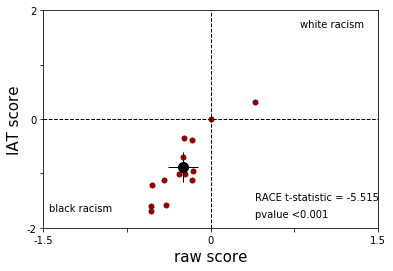

Ttest_1sampResult(statistic=-5.515393742315578, pvalue=9.951279817522823e-05)
14


In [21]:
##PLOT

plt.figure()

for i in range(len(RAWrace)):
    plt.plot(RAWrace[i], IATrace[i], marker='.', markersize=10, color='darkred' )


#plt.xlim([-0.5,0.5])
#plt.xticks([-0.5, -0.25, 0, 0.25, 0.5], ['-0.5', '', '0', '', '0.5'], fontsize=10)
plt.xlim([-1.5,1.5])
plt.xticks([-1.5, -0.75, 0, 0.75, 1.5], ['-1.5', '', '0', '', '1.5'], fontsize=10)

#plt.plot([-0.5, 0.5], [0,0], 'k--', linewidth=1)
plt.plot([-1.5, 1.5], [0,0], 'k--', linewidth=1)


plt.ylim([-2,2])
plt.yticks([-2,-1, 0, 1,2], ['-2','', '0', '','2'], fontsize=10)

plt.plot( [0,0], [-2,2], 'k--', linewidth=1)
plt.xlabel('raw score', fontsize=15)
plt.ylabel('IAT score', fontsize=15)

plt.plot(np.mean(RAWrace), np.mean(IATrace), marker='+', markersize=30, color='k' )
plt.plot(np.mean(RAWrace), np.mean(IATrace), marker='.', markersize=20, color='k' )

stats1 = stats.ttest_1samp(IATrace, 0)

# plt.text( 0.1, -1.5, 'RACE t-statistic = ' + str(np.round(stats[0], 3)), fontsize=10 )
# plt.text( 0.1, -1.8, 'pvalue = ' + str(np.round(stats[1], 3)), fontsize=10 )
plt.text( 0.4, -1.5, 'RACE t-statistic = ' + str(np.round(stats1[0], 3)), fontsize=10 )
#plt.text( 0.4, -1.8, 'pvalue = ' + str(np.round(stats1[1], 3)), fontsize=10 )
plt.text( 0.4, -1.8, 'pvalue <0.001', fontsize=10 )


# plt.text( 0.3, 1.7, 'white racism' , fontsize=10 )
# plt.text( -0.45, -1.7, 'black racism' , fontsize=10 )
plt.text( 0.8, 1.7, 'white racism' , fontsize=10 )
plt.text( -1.45, -1.7, 'black racism' , fontsize=10 )


plt.savefig('biblios1.png', transparent=True)
plt.show(block=False)

#plt.savefig('IATscatter.png', dpi=300, facecolor='w', edgecolor='w',
#            orientation='portrait', papertype=None, format=None,
#            transparent=False, bbox_inches=None, pad_inches=0.1)
         

print(stats1)
print(len(IATrace))


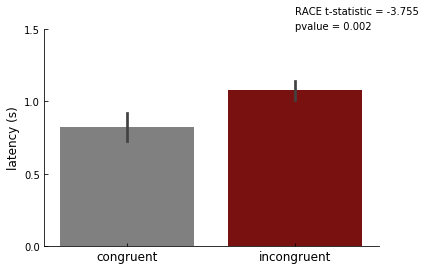

Ttest_relResult(statistic=-3.7546751137094865, pvalue=0.0024059776827284425)


In [24]:
########### REACTION TIMES

c_ = iat_race['congruent mean RT'].values
c_adj = iat_race['congruent adjmean RT'].values
congruent = pd.DataFrame({'reaction time': c_, 'reaction time adj': c_adj})
congruent['condition'] = 'congruent'


i_ = iat_race['incongruent mean RT'].values
i_adj = iat_race['incongruent adjmean RT'].values
incongruent = pd.DataFrame({'reaction time': i_,  'reaction time adj': i_adj})
incongruent['condition'] = 'incongruent'


reaction_time = pd.concat([congruent, incongruent])
#reaction_time['reaction time'] =  reaction_time['reaction time'].astype(float)

plt.figure()
sns.barplot(x='condition', y='reaction time', palette=['grey', 'darkred'], ci=68, estimator=np.mean, data=reaction_time)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.ylim(0,1.5)
plt.yticks([0,0.5,1,1.5])
plt.ylabel('latency (s)', fontsize=12)
plt.xlabel('')
plt.xticks([0,1], ['congruent', 'incongruent'], fontsize=12)
stats2 = scipy.stats.ttest_rel(c_, i_)
plt.text( 1, 1.6, 'RACE t-statistic = ' + str(np.round(stats2[0], 3)), fontsize=10 )
plt.text( 1, 1.5, 'pvalue = ' + str(np.round(stats2[1], 3)), fontsize=10 )
plt.show(block=False)
print(stats2)


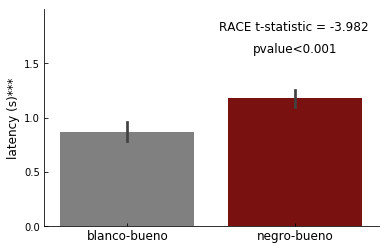

Ttest_relResult(statistic=-3.9819762455730854, pvalue=0.001564299730455854)


In [23]:

plt.figure()
sns.barplot(x='condition', y='reaction time adj', palette=['grey', 'darkred'], ci=68, estimator=np.mean, data=reaction_time)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.ylim(0,2)
plt.yticks([0,0.5,1,1.5])
plt.ylabel('latency (s)***', fontsize=12)
plt.xlabel('')
plt.xticks([0,1], ['blanco-bueno', 'negro-bueno'], fontsize=12)
stats3 = scipy.stats.ttest_rel(c_adj, i_adj)
plt.text( 0.55, 1.8, 'RACE t-statistic = ' + str(np.round(stats3[0], 3)), fontsize=12 )
#plt.text( 0.5, 1.5, 'pvalue = ' + str(np.round(stats3[1], 3)), fontsize=10 )
plt.text( 0.75, 1.6, 'pvalue<0.001', fontsize=12)
plt.savefig('biblios.png', transparent=True)
plt.show(block=False)

print(stats3)
